<a href="https://colab.research.google.com/github/saqlineniam/Real-Time-Apple-Detection-for-Robust-Multi-Object-Tracking-in-Orchard-Environments/blob/main/AppleMOT_to_YOLO_COCO_dataset_convert_and_YOLO_V8s_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import json
import base64
import zlib
from tqdm.notebook import tqdm
import os # Import os module
import shutil # Import shutil module

In [2]:
# --- Helper function from your code to decode the bitmaps ---
def decode_bitmap(bitmap_data):
    try:
        compressed_data = base64.b64decode(bitmap_data)
        png_data = zlib.decompress(compressed_data)
        mask_patch = cv2.imdecode(np.frombuffer(png_data, np.uint8), cv2.IMREAD_UNCHANGED)
        if len(mask_patch.shape) > 2:
            mask_patch = mask_patch[:, :, 3]
        return mask_patch
    except Exception:
        return None

def convert_to_yolo_segmentation(dataset_root, output_root):
    """
    Converts the AppleMOT dataset into the YOLOv8 segmentation format.
    """
    # Clean up previous runs
    if os.path.exists(output_root):
        shutil.rmtree(output_root)

    for split in ['train', 'testing']:
        split_name = 'val' if split == 'testing' else 'train'
        print(f"--- Processing '{split_name}' split ---")

        # Create YOLOv8 directory structure
        img_dest_dir = os.path.join(output_root, 'images', split_name)
        lbl_dest_dir = os.path.join(output_root, 'labels', split_name)
        os.makedirs(img_dest_dir, exist_ok=True)
        os.makedirs(lbl_dest_dir, exist_ok=True)

        img_src_dir = os.path.join(dataset_root, split, 'img')
        ann_src_dir = os.path.join(dataset_root, split, 'ann')

        image_filenames = sorted(os.listdir(img_src_dir))

        for filename in tqdm(image_filenames, desc=f"Converting {split_name}"):
            # Copy image file to the new structure
            shutil.copy(os.path.join(img_src_dir, filename), img_dest_dir)

            # --- Annotation Processing ---
            ann_path = os.path.join(ann_src_dir, filename + '.json')
            if not os.path.exists(ann_path): continue

            with open(ann_path, 'r') as f: ann_data = json.load(f)

            img_height = ann_data['size']['height']
            img_width = ann_data['size']['width']
            yolo_labels = []

            for obj in ann_data.get('objects', []):
                if obj.get('geometryType') != 'bitmap': continue

                # Decode the bitmap into a small mask patch
                mask_patch = decode_bitmap(obj['bitmap']['data'])
                if mask_patch is None: continue

                # Create a full-size mask and place the patch at its origin
                origin = obj['bitmap']['origin']; x_origin, y_origin = origin
                full_mask = np.zeros((img_height, img_width), dtype=np.uint8)
                h_patch, w_patch = mask_patch.shape
                y_end, x_end = min(y_origin + h_patch, img_height), min(x_origin + w_patch, img_width)
                full_mask[y_origin:y_end, x_origin:x_end] = mask_patch[:y_end-y_origin, :x_end-x_origin]

                # Find contours (polygons) from the mask
                contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if not contours: continue

                # Format each polygon for YOLO
                for contour in contours:
                    if contour.size < 6: continue # A polygon needs at least 3 points (6 values)

                    # Normalize polygon coordinates
                    normalized_contour = contour.flatten().astype(float)
                    normalized_contour[0::2] /= img_width  # Normalize x
                    normalized_contour[1::2] /= img_height # Normalize y

                    # Create the YOLO string: class_id x1 y1 x2 y2 ...
                    # Since we only have 'apple', the class_id is 0
                    yolo_string = f"0 {' '.join(map(str, normalized_contour))}"
                    yolo_labels.append(yolo_string)

            # Save the corresponding .txt label file
            label_filename = os.path.splitext(filename)[0] + '.txt'
            with open(os.path.join(lbl_dest_dir, label_filename), 'w') as f:
                f.write('\n'.join(yolo_labels))

In [3]:
# --- Main Execution ---
# !! IMPORTANT !! Update this path to your dataset folder in Google Drive
dataset_path = "/content/drive/MyDrive/dataset-ninja/apple-mots"

# Define where the new YOLO-formatted dataset will be saved
output_yolo_path = "/content/drive/MyDrive/AppleMOT_YOLOv8"

# # Run the conversion
convert_to_yolo_segmentation(dataset_path, output_yolo_path)

print(f"\nConversion complete! YOLOv8 dataset is ready at: {output_yolo_path}")

--- Processing 'train' split ---


Converting train:   0%|          | 0/1147 [00:00<?, ?it/s]

--- Processing 'val' split ---


Converting val:   0%|          | 0/1051 [00:00<?, ?it/s]


Conversion complete! YOLOv8 dataset is ready at: /content/drive/MyDrive/AppleMOT_YOLOv8


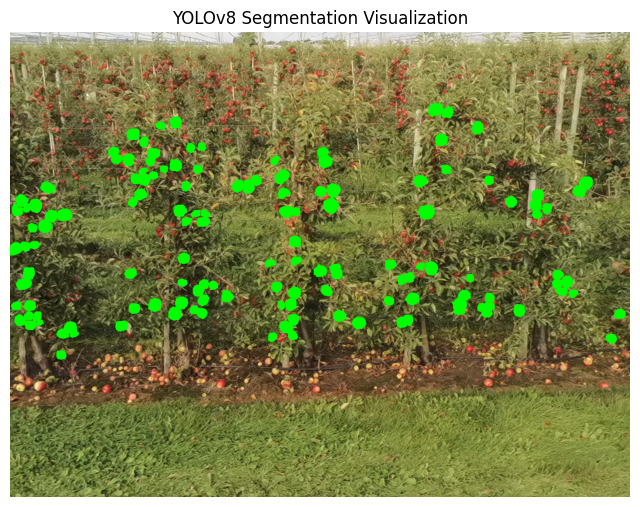

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def visualize_yolo_segmentation(image_path, label_path):
    """
    Visualizes YOLOv8 segmentation polygons on top of the image.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Could not load image:", image_path)
        return

    h, w, _ = image.shape

    # Read the YOLO segmentation label
    if not os.path.exists(label_path):
        print("❌ Label file not found:", label_path)
        return

    with open(label_path, "r") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    # Draw polygons
    for line in lines:
        parts = line.split()
        class_id = int(parts[0])
        coords = np.array(list(map(float, parts[1:])))

        # Convert normalized coordinates to pixel coordinates
        pts = coords.reshape(-1, 2)
        pts[:, 0] *= w
        pts[:, 1] *= h
        pts = pts.astype(np.int32)

        # Draw polygon
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.fillPoly(image, [pts], color=(0, 255, 0, 40))  # light fill

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("YOLOv8 Segmentation Visualization")
    plt.show()


# --- Example usage ---
# Replace with one of your converted images and labels
image_path = "/content/drive/MyDrive/AppleMOT_YOLOv8/images/train/0000_000000.png"
label_path = "/content/drive/MyDrive/AppleMOT_YOLOv8/labels/train/0000_000000.txt"

visualize_yolo_segmentation(image_path, label_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import yaml

# Path to the YOLO dataset we just created
yolo_dataset_path = "/content/drive/MyDrive/AppleMOT_YOLOv8"

# Data for the YAML file
data_yaml = {
    'path': yolo_dataset_path,
    'train': os.path.join(yolo_dataset_path, 'images/train'),
    'val': os.path.join(yolo_dataset_path, 'images/val'),
    'names': {
        0: 'apple'
    }
}

# Write the YAML file
yaml_path = os.path.join(yolo_dataset_path, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"data.yaml file created at: {yaml_path}")

data.yaml file created at: /content/drive/MyDrive/AppleMOT_YOLOv8/data.yaml


In [6]:
# Install the library
!pip install ultralytics -q

In [8]:


# Import the main YOLO class and other tools
from ultralytics import YOLO
import os
import shutil
from google.colab import drive
import yaml
from PIL import Image
from IPython.display import display

In [9]:
from ultralytics import YOLO

# Path to your YAML file
data_yaml_path = "/content/drive/MyDrive/AppleMOT_YOLOv8/data.yaml"

# Load a pre-trained YOLOv8 segmentation model
model = YOLO('yolov8s-seg.pt')

# Train with early stopping
results = model.train(
    data=data_yaml_path,
    epochs=150,
    imgsz=640,
    batch=32,
    patience=10,  # 🧠 Stop if no improvement after 15 epochs
    project="/content/drive/MyDrive/YOLOv8_Apple_Training",
    name="apple_segmentation_bs64"
)

print("\n✅ Training complete!")


Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AppleMOT_YOLOv8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=apple_segmentation_bs64, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

--- Comparing for image: 0008_000294.png ---


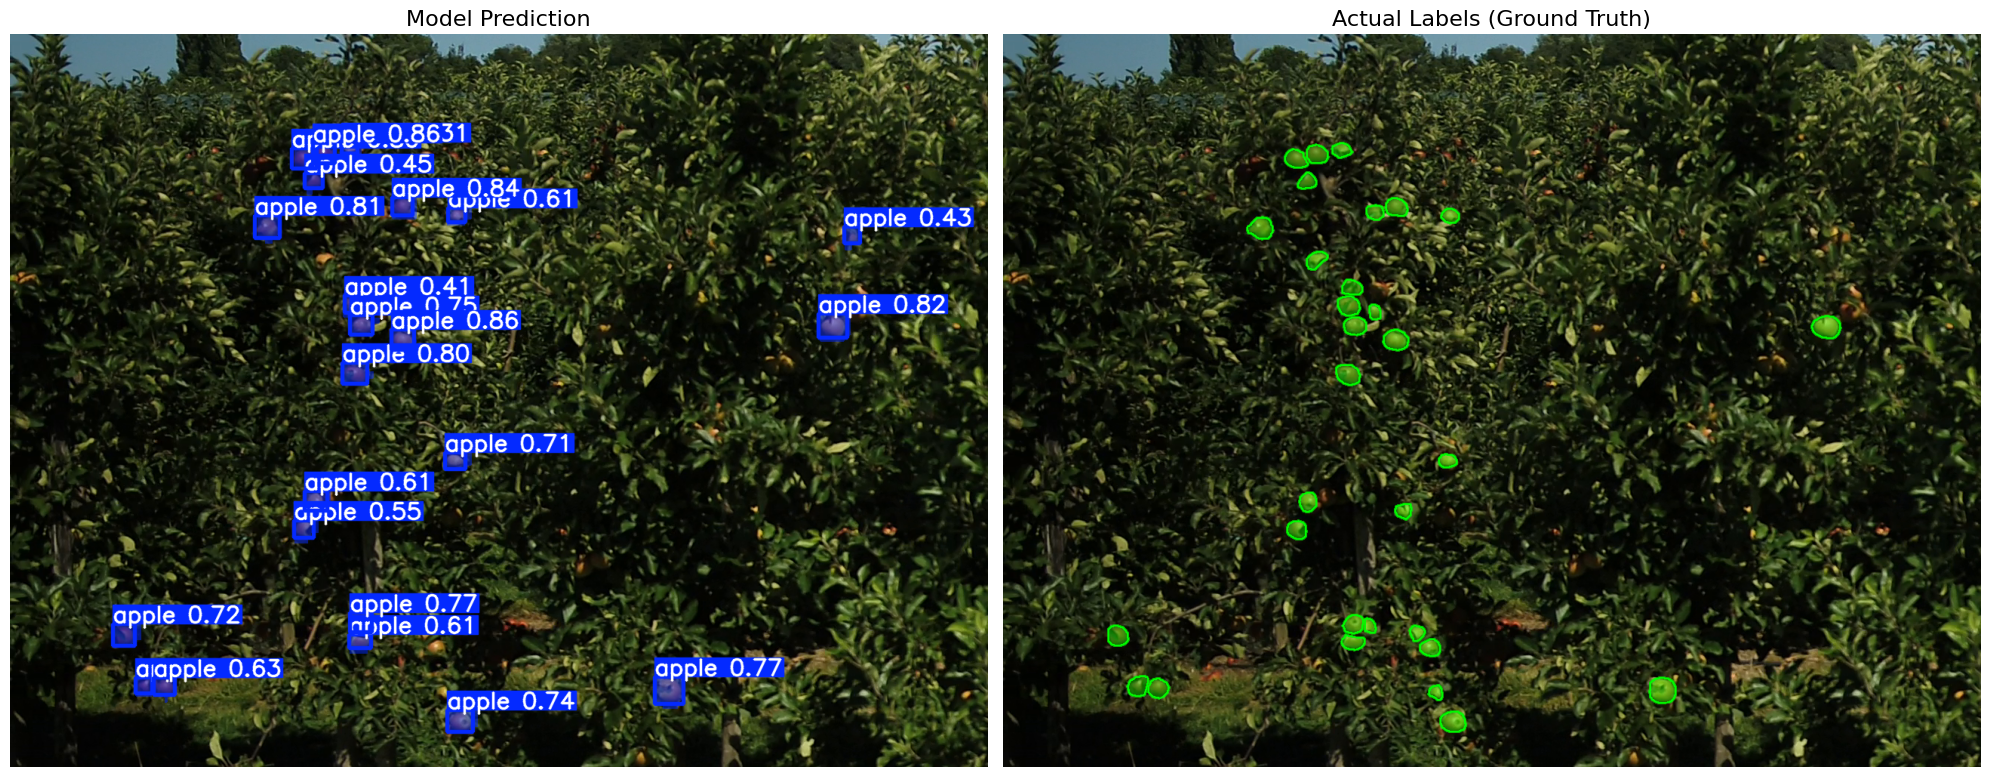

--- Comparing for image: 0006_000033.png ---


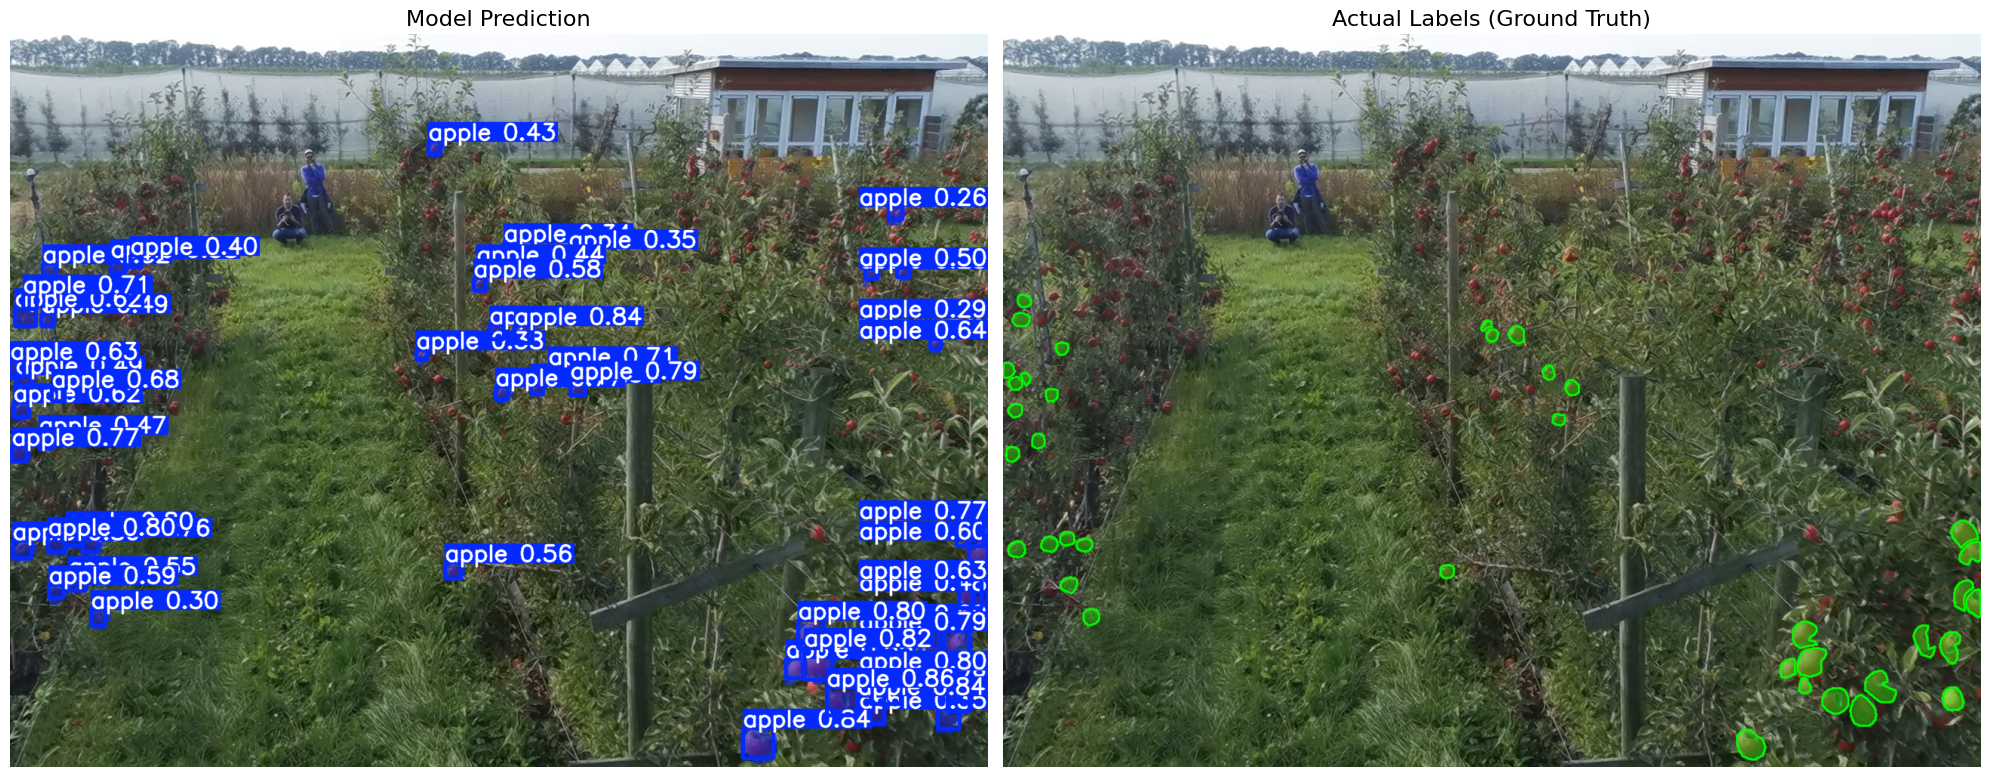

--- Comparing for image: 0008_000132.png ---


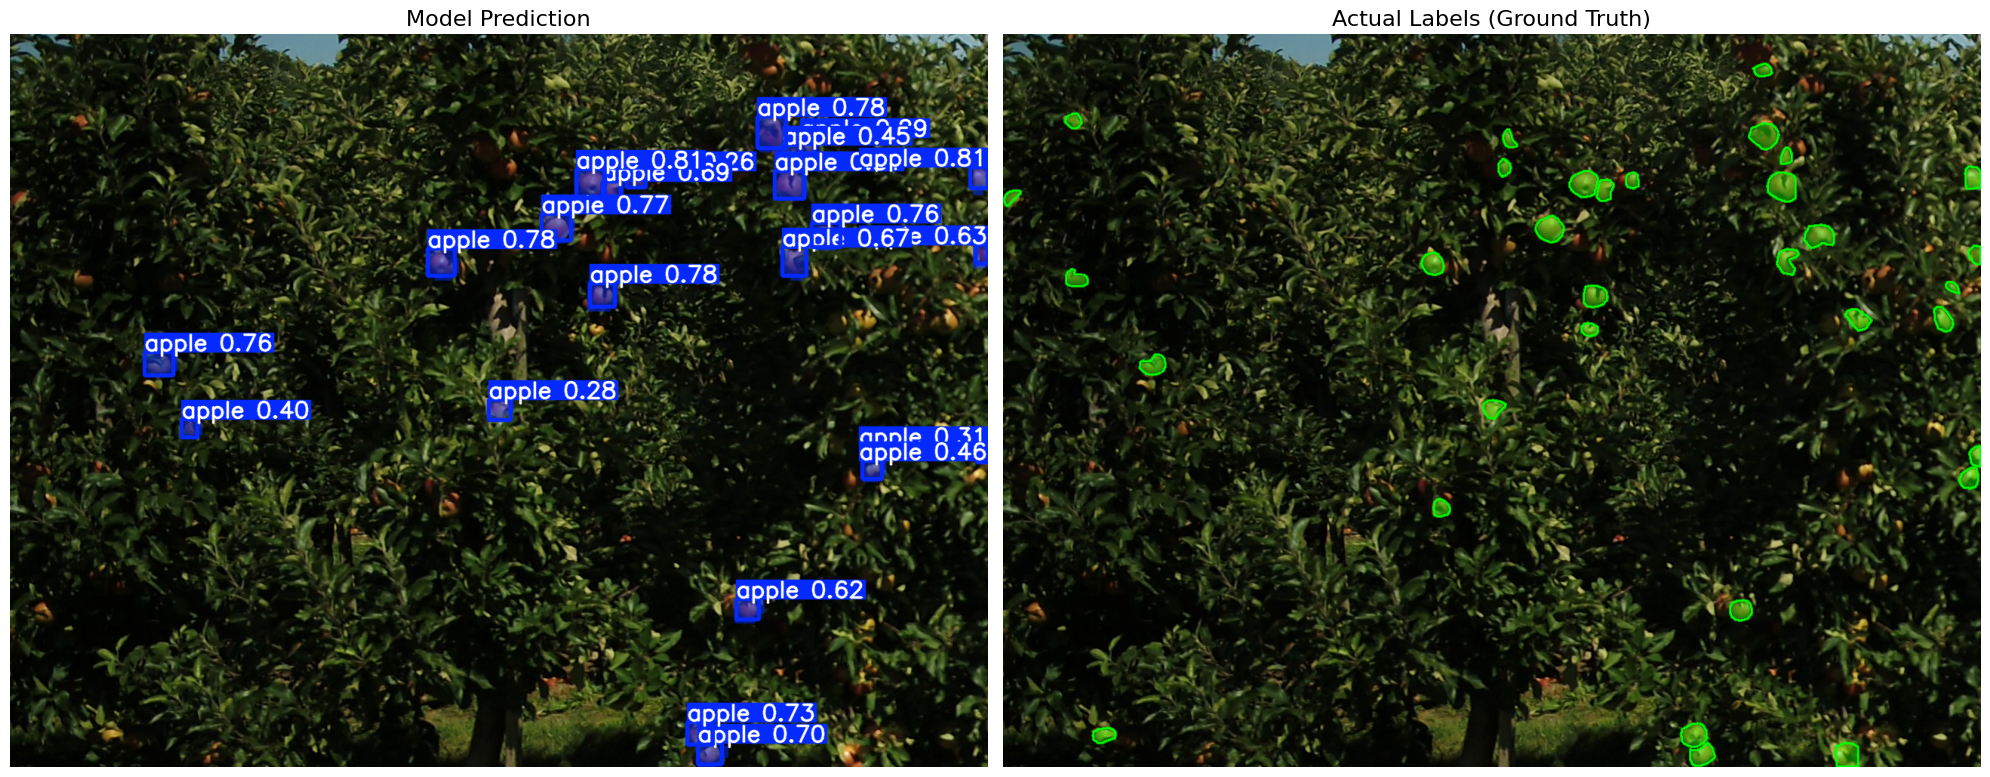

--- Comparing for image: 0011_000002.png ---


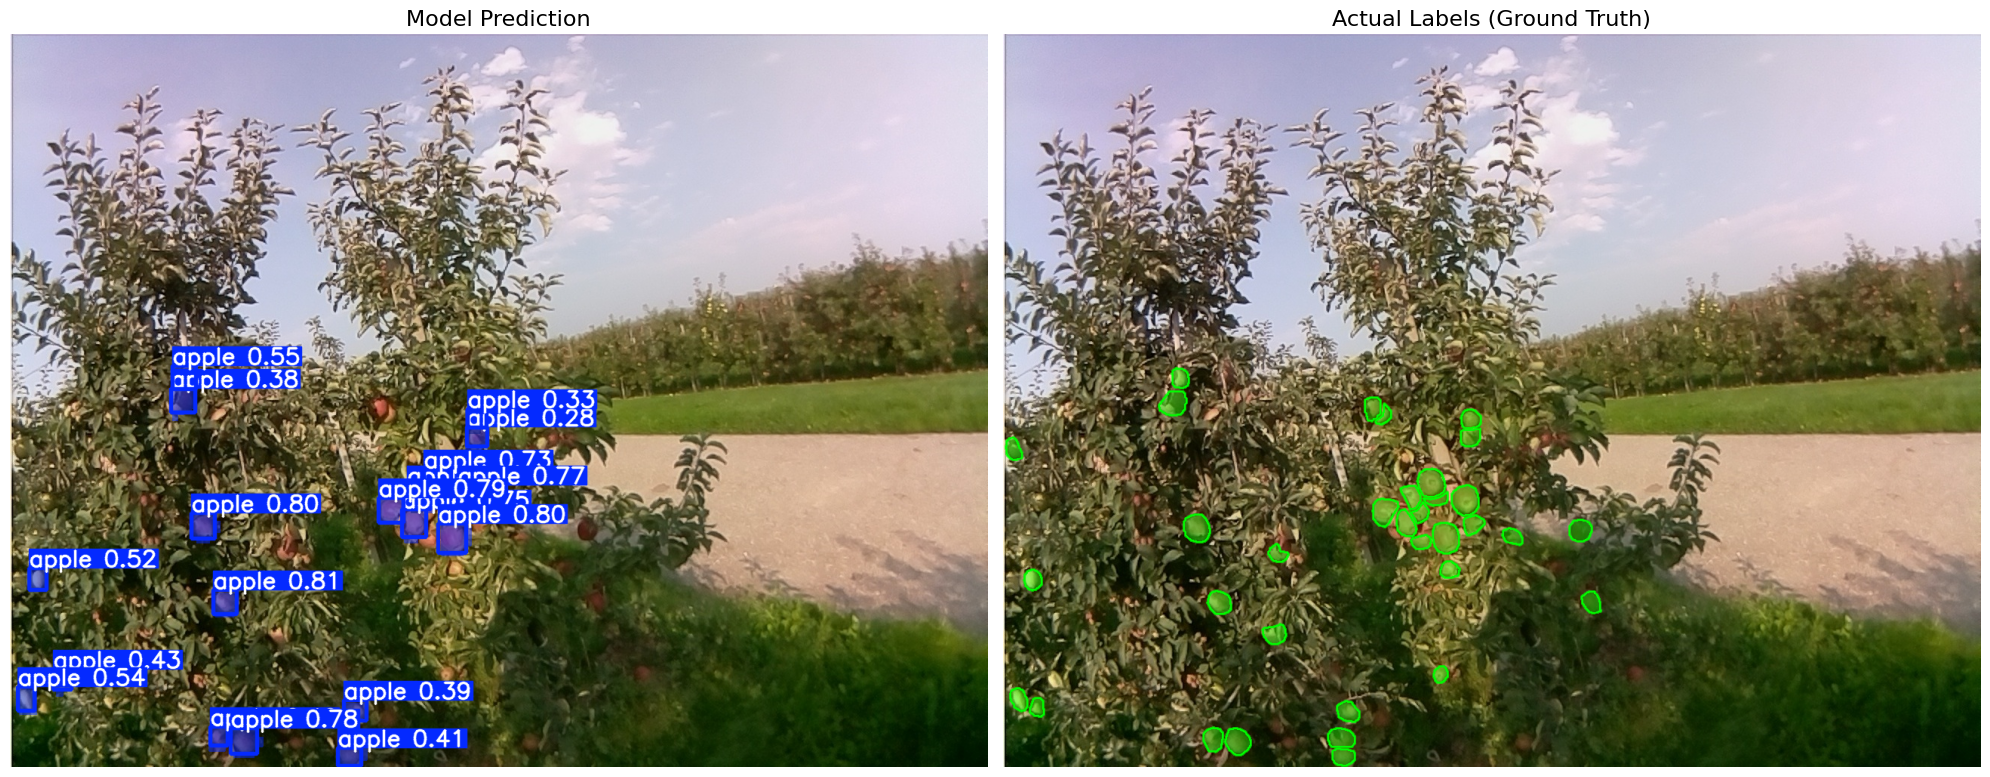

In [11]:
# ==> RUN THIS CELL TO COMPARE PREDICTIONS VS. ACTUAL LABELS <==

from ultralytics import YOLO
from PIL import Image
from IPython.display import display
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Helper Function to Draw Ground Truth Polygons ---
def draw_ground_truth(image_path, label_path):
    """
    Reads a YOLOv8 label file and draws the ground truth polygons on the image.
    """
    # Read the original image
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # Create a transparent overlay for the masks
    overlay = image.copy()
    alpha = 0.4  # Transparency factor

    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                # Class index is parts[0], but we only have one class ('apple')

                # De-normalize polygon coordinates
                polygon_norm = np.array(parts[1:], dtype=np.float32)
                polygon_pixels = polygon_norm.reshape(-1, 2)
                polygon_pixels[:, 0] *= w
                polygon_pixels[:, 1] *= h
                polygon_pixels = polygon_pixels.astype(np.int32)

                # Draw the filled polygon on the overlay
                cv2.fillPoly(overlay, [polygon_pixels], color=(0, 255, 0), lineType=cv2.LINE_AA)
                # Draw the polygon outline on the main image
                cv2.polylines(image, [polygon_pixels], isClosed=True, color=(0, 255, 0), thickness=2)

        # Blend the overlay with the original image
        image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
        return image

    except FileNotFoundError:
        # If there are no objects in an image, there's no label file. Return the original.
        return image

# --- Main Visualization Logic ---

# 1. DEFINE PATHS
results_path = "/content/drive/MyDrive/YOLOv8_Apple_Training/apple_segmentation_bs642"
best_model_path = os.path.join(results_path, "/content/drive/MyDrive/YOLOv8_Apple_Training/apple_segmentation_bs64/weights/best.pt")
yolo_dataset_path = "/content/drive/MyDrive/AppleMOT_YOLOv8"
val_images_path = os.path.join(yolo_dataset_path, "images/val")
val_labels_path = os.path.join(yolo_dataset_path, "labels/val")

# Number of sample images to display
NUM_SAMPLES = 4

# 2. LOAD THE TRAINED MODEL
model = YOLO(best_model_path)

# 3. GET A LIST OF RANDOM IMAGES
image_files = os.listdir(val_images_path)
sample_images = random.sample(image_files, min(NUM_SAMPLES, len(image_files)))

# 4. LOOP, PREDICT, AND VISUALIZE
for image_name in sample_images:
    image_path = os.path.join(val_images_path, image_name)
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(val_labels_path, label_name)

    print(f"--- Comparing for image: {image_name} ---")

    # --- Get Model Prediction ---
    results_list = model.predict(image_path, verbose=False) # verbose=False for cleaner output
    prediction_array = results_list[0].plot() # .plot() returns a BGR np array

    # --- Get Ground Truth Visualization ---
    ground_truth_array = draw_ground_truth(image_path, label_path)

    # --- Display Side-by-Side using Matplotlib ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Prediction Image
    ax1.imshow(cv2.cvtColor(prediction_array, cv2.COLOR_BGR2RGB))
    ax1.set_title("Model Prediction", fontsize=16)
    ax1.axis('off')

    # Ground Truth Image
    ax2.imshow(cv2.cvtColor(ground_truth_array, cv2.COLOR_BGR2RGB))
    ax2.set_title("Actual Labels (Ground Truth)", fontsize=16)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()